# <center> Исследование данных HR-агенства

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы:

- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.

Ответить на эти вопросы нам помогут данные о заработной плате в области науки о данных (заработная плата в сфере Data Science).

Данные содержат следующие столбцы:
*   *work_year* — год, в котором была выплачена заработная плата;
*   *experience_level* — опыт работы на этой должности в течение года: EN — Entry-level/Junior, MI — Mid-level/Intermediate, SE — Senior-level/Expert, EX — Executive-level/Director;
*   *employment_type* — тип трудоустройства для этой роли: T — неполный рабочий день, FT — полный рабочий день, CT — контракт, FL — фриланс;
*   *job_title* — роль, в которой соискатель работал в течение года;
*   *salary* — общая выплаченная валовая сумма заработной платы;
*   *salary_currency* — валюта выплачиваемой заработной платы в виде кода валюты ISO 4217;
*   *csalary_in_usd* — зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com.);
*   *employee_residence* — Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166;
*   *remote_ratio* — 	Общий объём работы, выполняемой удалённо. Возможные значения: 0 — удалённой работы нет (менее 20 %), 50 — частично удалённая работа, 100 — полностью удалённая работа (более 80 %);
*   *company_location* — Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166;
*   *company_size* — Среднее количество людей, работавших в компании в течение года: S — менее 50 сотрудников (небольшая компания), M — от 50 до 250 сотрудников (средняя компания), L — более 250 сотрудников (крупная компания).

Источник датасета: ["Data Science Job Salaries” (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

## Загрузка данных

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [3]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей, без пропущенных значений.

In [5]:
# Проверяем данные на наличие дубликатов
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

Количество дубликатов: 0


Информативным признаком о заработной плате является столбец salary_in_usd, в котором заработная плата приведена для всех объектов в одной валюте, таким образом, признаки salary и salary_currency не несут полезной информации.

In [17]:
data = data.drop(['salary', 'salary_currency'], axis = 1)

В представленном датасете числовым признаком является:
*   *salary_in_usd*

Остальные признаки можно отнести к категориальным. В том числе и признак work_year, так как данные представлены за 3 года (с 2020 до 2022), можно говорить о том, что данный признак имеет ограниченный набор значений, каждый объект данных принадлежит одному из трех годов. 

In [22]:
# Основные статистические характеристики для числового признака salary_in_usd
data['salary_in_usd'].describe()

count       607.000000
mean     112297.869852
std       70957.259411
min        2859.000000
25%       62726.000000
50%      101570.000000
75%      150000.000000
max      600000.000000
Name: salary_in_usd, dtype: float64

Можно отметить, что размер минимальной и макисмальной заработной платы существенно отличается. Максимальная заработная плата больше минимальной в 209 раз.

In [20]:
# Основные статистические характеристики для признаков типа 'object'
data.describe(include=['object'])

,experience_level,employment_type,job_title,employee_residence,company_location,company_size
count,607,607,607,607,607,607
unique,4,4,50,57,50,3
top,SE,FT,Data Scientist,US,US,M
freq,280,588,143,332,355,326


Наиболее часто встречаются должности уровня Senior/Expert с полным рабочим днем и ролью Data Scientist. Самой популярной страной проживания сотрудника и страной главного офиса работодателя является США, а большинство компаний - средние с количеством сотрудников от 50 до 250.

## Разведывательный анализ данных

### Визуальный анализ данных

#### Распределение заработной платы среди всех сотрудников

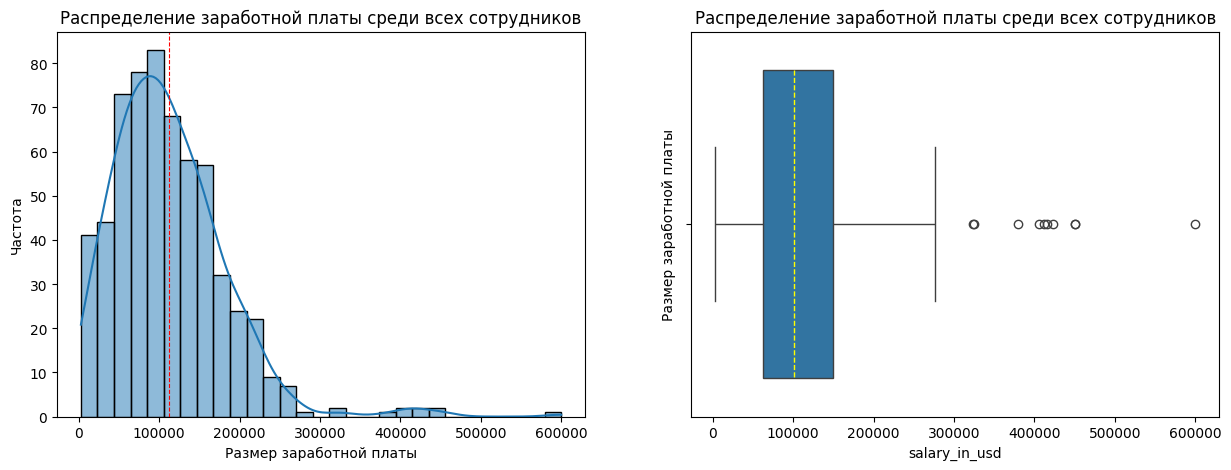

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер заработной платы', ylabel='Частота')
axes[0].set_title('Распределение заработной платы среди всех сотрудников')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "yellow", "linestyle": '--'})
axes[1].set(ylabel='Размер заработной платы')
axes[1].set_title('Распределение заработной платы среди всех сотрудников')

plt.show()

Распределение заработной платы отлично от нормального, имеются выбросы.

#### Размер заработной платы по годам.

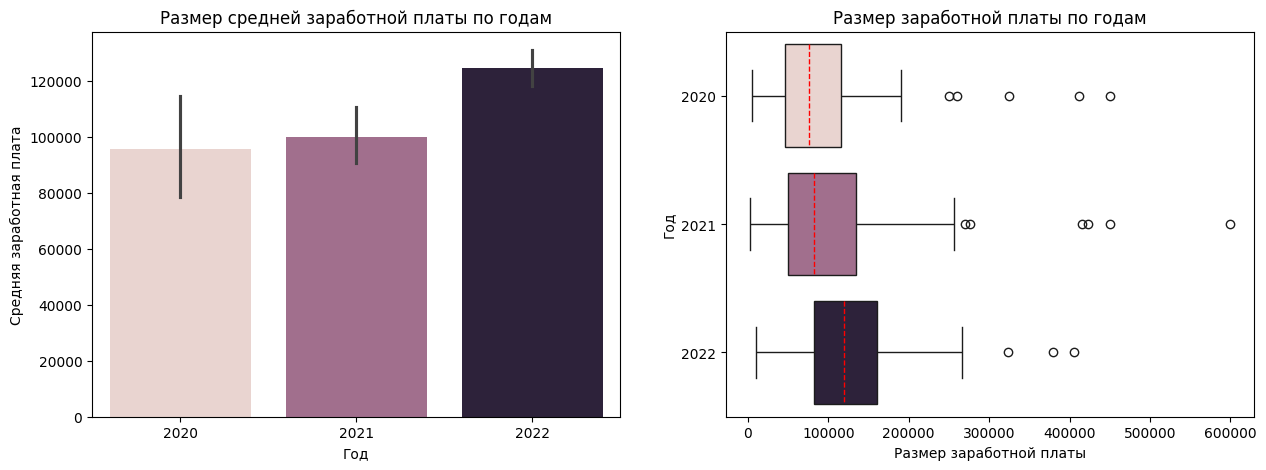

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Строим столбчатую диаграмму для визуализации размера средней заработной платы по годам
sns.barplot(
            data, 
            x='work_year', 
            y='salary_in_usd', 
            hue='work_year', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Год', ylabel='Средняя заработная плата')
axes[0].set_title('Размер средней заработной платы по годам')

sns.boxplot(
            data, 
            x='salary_in_usd', 
            y='work_year', 
            orient='h', 
            hue='work_year',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Размер заработной платы', ylabel='Год')
axes[1].set_title('Размер заработной платы по годам')

plt.show()

In [46]:
salary_year = data.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Заработная плата по годам')
salary_year

Заработная плата по годам


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,72.0,95813.00,82831.80,5707.0,45724.5,75544.0,115526.0,450000.0
2021,217.0,99853.79,80225.11,2859.0,50000.0,82528.0,135000.0,600000.0
2022,318.0,124522.01,58183.65,10000.0,81666.0,120000.0,160000.0,405000.0


Можно отметить, что размер средней заработной платы в 2020 и 2021 году отличается незначительно, а в 2022 году средняя заработная плата вырастает на 25%. Это может говорить об увеличении спроса на специалистов, что соответственно привело к росту уровня заработной платы. При этом, в 2022 году макисмальная заработная плата была самая низкая. Так же среди всех трех лет наблюдений в 2021 году отмечена как самая высокая так и самая низкая заработная плата.

Размер заработной платы по годам имеет различия. Чтобы определить, являются ли эти различия статистически значимыми, необходимо провести статистическое тестирование.

#### Соотношение зарплаты Data Scientist и Data Engineer в 2022 году